In [ ]:
# NOTE: There is a typo with the rendered code blocks for shapiro-wilk test
# where it says failed to reject null hypothesis instead of rejected null hypothesis.

In [1]:
# COLAB ONLY : Install required packages
from importlib.util import find_spec
import os
os.chdir("./")
!pip install pydlm pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot as plot
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason, modelTuner
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import shapiro
from math import sqrt
from tqdm import tqdm
import warnings
import statsmodels
import pmdarima
import pickle

In [2]:
# Clean data, make a date-time index
import pandas as pd

def get_df(csvfile: str, param: str):
    df = pd.read_csv(csvfile)
    df = df.dropna()
    if param == "GHI" or param == "Wind Speed":
        sort_cols = ["Year", "Month", "Day", "Hour"]
        df.sort_values(by=sort_cols, inplace=True)
        if param == "GHI":
            df = df[(df["Hour"] > 7) & (df["Hour"] < 17)]
            df = df[["Year", "Month", "Day", "Hour", "GHI", "Clearsky GHI"]]
        else:
            df = df[["Year", "Month", "Day", "Hour", "Wind Speed"]]

        # Combine separate columns to create a 'datetime' column in the correct format
        df["datetime"] = pd.to_datetime(
        df["Year"].astype(int).astype(str) + '-' +
        df["Month"].astype(int).astype(str).str.zfill(2) + '-' +
        df["Day"].astype(int).astype(str).str.zfill(2) + ' ' +
        df["Hour"].astype(int).astype(str).str.zfill(2) + ':00:00')


    else:
        sort_cols = ["Year", "Month", "Day"]
        df.sort_values(by=sort_cols, inplace=True)
        df = df[["Year", "Month", "Day", "Wind Speed 50", "Wind Speed 10"]]
        df["datetime"] = (
            df["Year"].astype(str)
            + "-"
            + df["Month"].astype(str).str.zfill(2)
            + "-"
            + df["Day"].astype(str).str.zfill(2)
        )

    df["datetime"] = pd.to_datetime(df["datetime"])
    return df

In [3]:
def adf_test(df):
    adf = adfuller(df.values)
    print("------------------------------")
    print("ADF Statistic : " + adf[0].astype(str))
    print("p-value :", end=" ")
    print(adf[1])
    crit_val = adf[4]["5%"]
    if (adf[1] < 0.05) and (adf[0] < crit_val):
        print("The series is stationary")
    else:
        print("The series is NOT stationary")
    print("------------------------------")

In [4]:
from sklearn.model_selection import train_test_split
def split_data(df, type, dtype):
    train_size = int(0.8 * len(df))
    
    train = df.head(train_size)
    test = df.tail(len(df) - train_size)
    idx = test.index

    # Split the data into a training set and a test set
    train, test = train_test_split(df, train_size=train_size, test_size=len(df) - train_size, shuffle=False)
    idx = test.index

    regressor = df.tail(int(len(df))-1)
    df= df.head(int(len(df))-1)

    # Convert to numpy arrays (for pyDLM)
    df = np.asarray(df, dtype=float)
    train = np.asarray(train, dtype=float)
    test = np.asarray(test, dtype=float)
    regressor = np.asarray(regressor, dtype=float)

    return train, test, regressor, df, idx

In [6]:
# Create the dlm
def create_dlm(regressor, df, mtype, type):
    prd = 365
    if type == "Weekly":
        prd = 52
    elif type == "Monthly":
        prd = 12

    if(mtype == "Regressive"):
        dyn = dynamic(features=regressor[:len(regressor)], discount=0.99999, name="dyn", w=10)
        seas = seasonality(period=prd, name="Season", discount=0.99999, w=10)
        tr = trend(degree=1, discount=0.99999, name='linear_trend', w=10)
        dlmModel = dlm(df) + dyn + seas + tr
    elif(mtype == "Trend"): # Trend only model gives constant value
        dlmModel = dlm(df) + trend(2, name='lineTrend', w=10.0)
    elif(mtype == "Seasonal"):
            seas = seasonality(period=prd, name="Season", discount=0.99999, w=10)
            tr = trend(degree=1, discount=0.99999, name='linear_trend', w=10)
            dlmModel = dlm(df) + seas + tr

    # if type != "Daily":
        # dlmTuner = modelTuner(method = 'gradient_descent', loss = 'mse')
        # print("Tuning model...")
        # dlmModel = dlmTuner.tune(dlmModel, maxit = 100)
        # print("Tuning finished.")
        # print("Tuned d: {}".format(dlmTuner.getDiscounts()))

    dlmModel.fitForwardFilter()

    if mtype == "Regressive":
      dynMean = dlmModel.getMean(name='dyn')
    else:
      # to return dummy value
      dynMean = dlmModel.getMean(name='Season')

    return dlmModel, dlmModel.getMean(name='linear_trend'), dlmModel.getMean(name='Season'), dynMean

In [7]:
def plotDLMComp(tr, seas, dyn, mtype):
    if mtype == "Regressive":
        fig, axs = plt.subplots(3, 1)
        fig.suptitle('Regressive DLM Components')
        axs[2].plot(dyn)
        axs[2].set_ylabel('Regressive', fontsize=10)
        axs[2].get_yaxis().set_label_coords(-0.1,0.5)
    else:
        fig, axs = plt.subplots(2, 1)
        fig.suptitle('Seasonal DLM Components')

    axs[0].plot(tr)
    axs[0].set_ylabel('Trend', fontsize=10)
    axs[0].get_yaxis().set_label_coords(-0.1,0.5)
    axs[1].plot(seas)
    axs[1].set_ylabel('Seasonal', fontsize=10)
    axs[1].get_yaxis().set_label_coords(-0.1,0.5)

    plt.show()

In [38]:
# Make predictions given the dlm (Plot predictions and residuals)
def predict(dlmModel, test,train ):
    dlmModel.turnOff('CI')
    plt.figure(figsize = (13,5), dpi = 100)
    dlmModel.plotPredictN(N=len(test)+80, date=len(test)-1)
    (predictMean, predictVar) = dlmModel.predictN(N=len(test), date=len(test)-1)

    # MSE and Residuals
    residual = test.reshape(1, len(test)) - predictMean
    residual = np.asarray(residual, dtype=float)
    resMean = np.sum(residual) / len(test)
    residual = residual.reshape(len(test), 1)
    dlmErr = []
    dlmErr.append(sqrt(mean_squared_error(predictMean, test)))
    dlmErr.append(mean_absolute_error(predictMean, test))
    dlmErr.append(mean_absolute_percentage_error(predictMean, test))

    return predictMean, residual, resMean, dlmErr

In [35]:
def res_plot(RegdlmRes, SeasdlmRes,type):
    # Regressive
    plt.figure(figsize = (13,5), dpi = 100)
    plt.plot(RegdlmRes, label="Regressive", linestyle=':')
    plt.plot(SeasdlmRes, label="Seasonal", linestyle=':')
    plt.grid(visible=True, color='0.95')
    plt.title("Residuals", fontweight = 'bold')
    plt.show()

    # Histogram Plot
    if type != "Daily":
      RES = pd.DataFrame(list(zip(RegdlmRes["DLM Res"], SeasdlmRes["DLM Res"])), columns = ['Regressive', 'Seasonal'])
    else:
      RES = pd.DataFrame(list(zip(RegdlmRes["DLM Res"], SeasdlmRes["DLM Res"])), columns = ['Regressive', 'Seasonal'])
    RES.plot.kde()

    # Shapiro Wilk Test
    # def shapiroChk(pval):
    #   if pval < 0.05:
    #     print("     Null hypothesis rejected, residuals do not follow normal distribution")

    # print("---------SHAPIRO WILK-----------")
    # print("Regressive: {}".format(shapiro(RegdlmRes["DLM Res"])))
    # shapiroChk(shapiro(RegdlmRes["DLM Res"]).pvalue)
    # print("Seasonal: {}".format(shapiro(SeasdlmRes["DLM Res"])))
    # shapiroChk(shapiro(SeasdlmRes["DLM Res"]).pvalue)


In [10]:
def pred_plot(test, RegdlmMean, SeasdlmMean, param, type):
    if type != 'Daily':
      fig, axs = plt.subplots(2,1, figsize=(15, 10))
    else:
      fig, axs = plt.subplots(2,1, figsize=(10, 10))
    fig.suptitle('Predictions', fontweight = 'bold')
    axs[0].plot(RegdlmMean, label="Regressive", color='#1f77b4')
    axs[0].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
    axs[0].set_ylabel('Regressive', fontsize = 10)
    axs[1].plot(SeasdlmMean, label="Seasonal", color='#ff7f0e')
    axs[1].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
    axs[1].set_ylabel('Seasonal', fontsize = 10)

    for ax in axs.flat: ax.label_outer()
    ax.tick_params('x', labelrotation = 45)
    plt.show()

In [11]:
def openModel(val, file, type):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    if os.path.isfile(fname):
        return pd.read_pickle(fname)
    else:
        return pd.DataFrame()

In [12]:
def openList(val, file, type):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    if os.path.isfile(fname):
        with open(fname, "rb") as fp:
            x = pickle.load(fp)
        fp.close()
        return x
    else:
        return []

In [13]:
def saveList(val, file, type, list):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    # if not os.path.isfile(fname):
    with open(fname, "wb") as fp:
        pickle.dump(list, fp)

In [14]:
def saveModel(val, file, type, df):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    df.to_pickle(fname)

In [42]:
# ------------------------------------
# --------- Main function ------------
# ------------------------------------
def main_function(file, param, type):
    df = get_df(file, param)
    df = df[["datetime", param]]
    df.set_index("datetime", inplace=True)

    # Resampling data
    if type != "None":
        df = df.reset_index()
        if type == "Daily":
            # if file == "tiruvanantpuram.csv" or file == "cleaned_Bhadla.csv":
            #   df = df.tail(int(len(df) * 0.8))
            df = df.resample("D", on="datetime").mean()
        elif type == "Weekly":
            df = df.resample("W", on="datetime").mean()
        elif type == "Monthly":
            df = df.resample("M", on="datetime").mean()

    # Check for NaN values in the DataFrame
    if df.isnull().sum().sum() > 0:
      print("NaN values detected!")
      df.fillna(method='ffill', inplace=True)  # Fill NaN values with the previous timestamp's value


    # # Check for infinite values
    if np.isinf(df).sum().sum() > 0:
        print("Infinite values detected!")
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

    print("Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nDescribe:\n", df.describe())
    print("\nHead:\n", df.head())
    print("\nTail:\n", df.tail())
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nNumber of Unique Values:\n", df.nunique())

    # ADF Test and TS Decomposition
    adf_test(df)
    decomp = seasonal_decompose(df, model="additive")
    decomp.plot()
    plt.show()

    (train, test, regressor, df, idx) = split_data(df, type, param)
    print(train.shape, test.shape, regressor.shape, df.shape)

    # Reg DLM
    print("--------------REGRESSIVE DLM---------------")
    # Check if data exists, use that otherwise create and save for later
    RegdlmMean = openModel("RegdlmMean", file, type)
    RegdlmRes = openModel("RegdlmRes", file, type)
    RegdlmErr = openList("RegdlmErr", file, type)
    tr = openList("Regtr", file, type)
    dyn = openList("Regdyn", file, type)
    seas = openList("Regseas", file, type)
    if RegdlmMean.empty or RegdlmRes.empty or (not RegdlmErr) or (not tr) or (not dyn) or (not seas):
      (RegdlmModel, tr, seas, dyn) = create_dlm(regressor, df, "Regressive", type)
      (RegdlmMean, RegdlmRes, RegdlmResMean, RegdlmErr) = predict(RegdlmModel, test,train)
      RegdlmMean = pd.DataFrame(RegdlmMean, index = idx, columns = ['DLM'])
      RegdlmRes = pd.DataFrame(RegdlmRes, index = idx, columns = ['DLM Res'])
      # saveModel("RegdlmMean", file, type, RegdlmMean)
      # saveModel("RegdlmRes", file, type, RegdlmRes)
      # saveList("RegdlmErr", file, type, RegdlmErr)
      # saveList("Regtr", file, type, tr)
      # saveList("Regdyn", file, type, dyn)
      # saveList("Regseas", file, type, seas)

    plotDLMComp(tr, seas, dyn, "Regressive")

    print("--------------SEASONAL DLM---------------")
    # Check if data exists, use that otherwise create and save for later
    SeasdlmMean = openModel("SeasdlmMean", file, type)
    SeasdlmRes = openModel("SeasdlmRes", file, type)
    SeasdlmErr = openList("SeasdlmErr", file, type)
    tr = openList("Seastr", file, type)
    dyn = openList("Seasdyn", file, type)
    seas = openList("Seasseas", file, type)
    if SeasdlmMean.empty or SeasdlmRes.empty or (not SeasdlmErr) or (not tr) or (not dyn) or (not seas):
      (SeasdlmModel, tr, seas, dyn) = create_dlm(regressor, df, "Seasonal", type)
      (SeasdlmMean, SeasdlmRes, SeasdlmResMean, SeasdlmErr) = predict(SeasdlmModel, test,train)
      SeasdlmMean = pd.DataFrame(SeasdlmMean, index = idx, columns = ['DLM'])
      SeasdlmRes = pd.DataFrame(SeasdlmRes, index = idx, columns = ['DLM Res'])
      # saveModel("SeasdlmMean", file, type, SeasdlmMean)
      # saveModel("SeasdlmRes", file, type, SeasdlmRes)
      # saveList("SeasdlmErr", file, type, SeasdlmErr)
      # saveList("Seastr", file, type, tr)
      # saveList("Seasdyn", file, type, dyn)
      # saveList("Seasseas", file, type, seas)

    plotDLMComp(tr, seas, dyn, "Seasonal")

    # Plot predictions on test data
    test = pd.DataFrame(test, index = idx, columns = ['Actual'])
    pred_plot(test, RegdlmMean, SeasdlmMean, param, type)


    # Plot residuals
    res_plot(RegdlmRes, SeasdlmRes, type)
    print("Error are :- ")
    print("Mean Square Error : {} Mean Aboulute Error : {} Mean Absolute Percentage Error : {}".format(RegdlmErr[0], RegdlmErr[1], RegdlmErr[2]))

In [47]:
# ------------------------------------
# -------- Various options -----------
# ------------------------------------
file = ["cleaned_Bhadla.csv"] 
param = ["GHI", "Clearsky GHI"]
type = ["None", "Daily", "Weekly", "Monthly","Hourly"] # 0-4
mtype = ["Regressive", "Seasonal"]

Bhadla GHI Monthly Predictions
Shape: (180, 1)

Data Types:
 GHI    float64
dtype: object

Describe:
               GHI
count  180.000000
mean   601.214059
std     93.343693
min    418.978495
25%    517.265013
50%    623.419056
75%    679.174612
max    745.218638

Head:
                    GHI
datetime              
2000-01-31  480.505376
2000-02-29  562.325397
2000-03-31  658.620072
2000-04-30  723.529630
2000-05-31  727.168459

Tail:
                    GHI
datetime              
2014-08-31  645.501792
2014-09-30  642.314815
2014-10-31  569.956989
2014-11-30  486.000000
2014-12-31  446.275986

Missing Values:
 GHI    0
dtype: int64

Number of Unique Values:
 GHI    180
dtype: int64

Correlation Matrix:
      GHI
GHI  1.0
------------------------------
ADF Statistic : -4.083253361187039
p-value : 0.0010321316547796105
The series is stationary
------------------------------


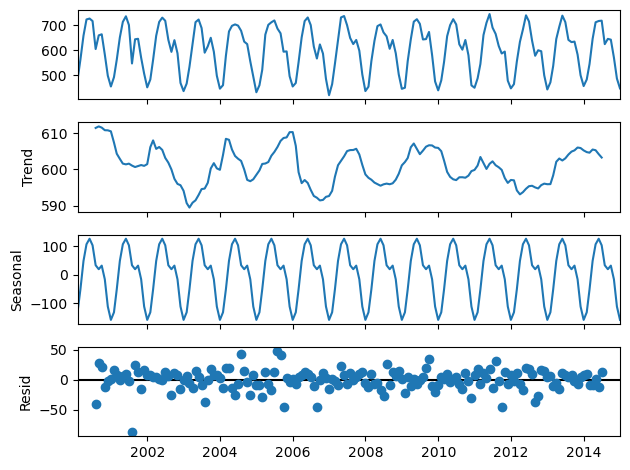

(144, 1) (36, 1) (179, 1) (179, 1)
--------------REGRESSIVE DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


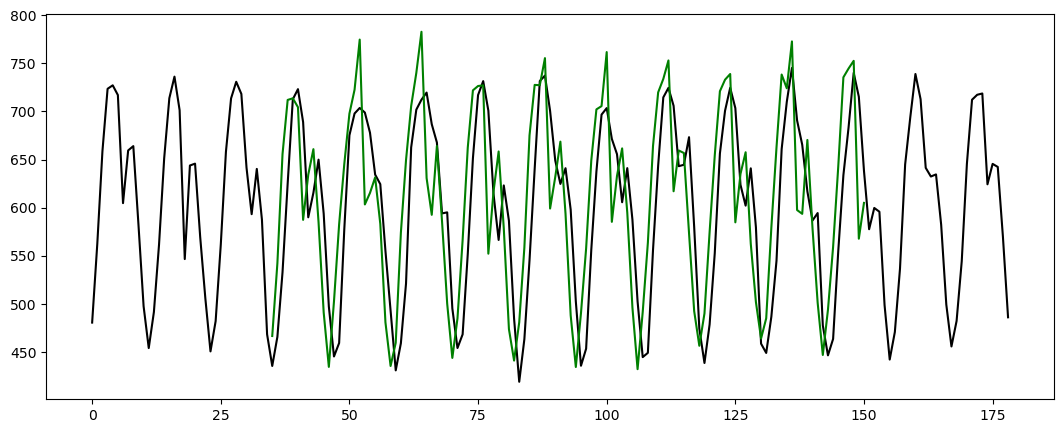

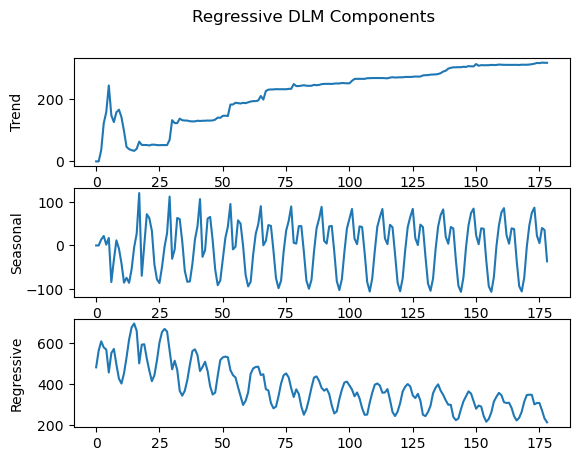

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


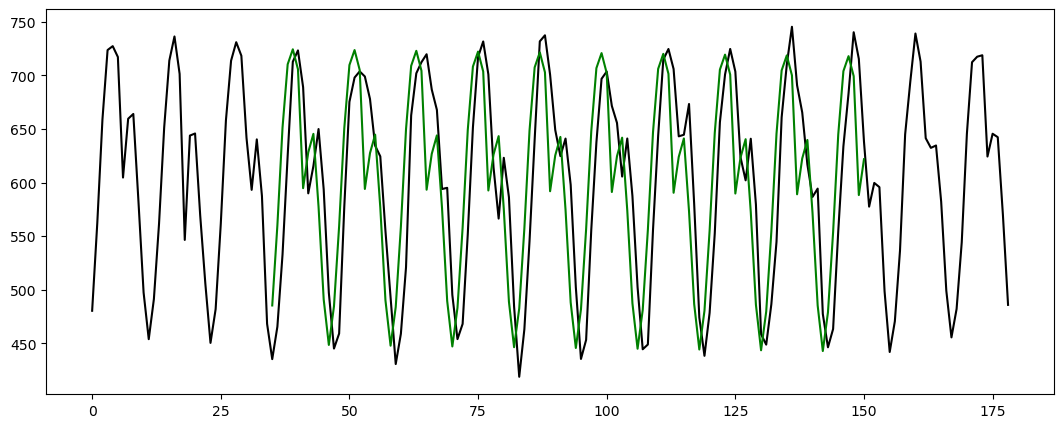

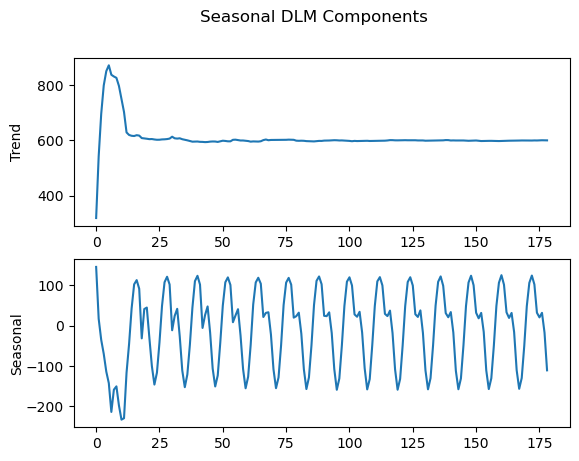

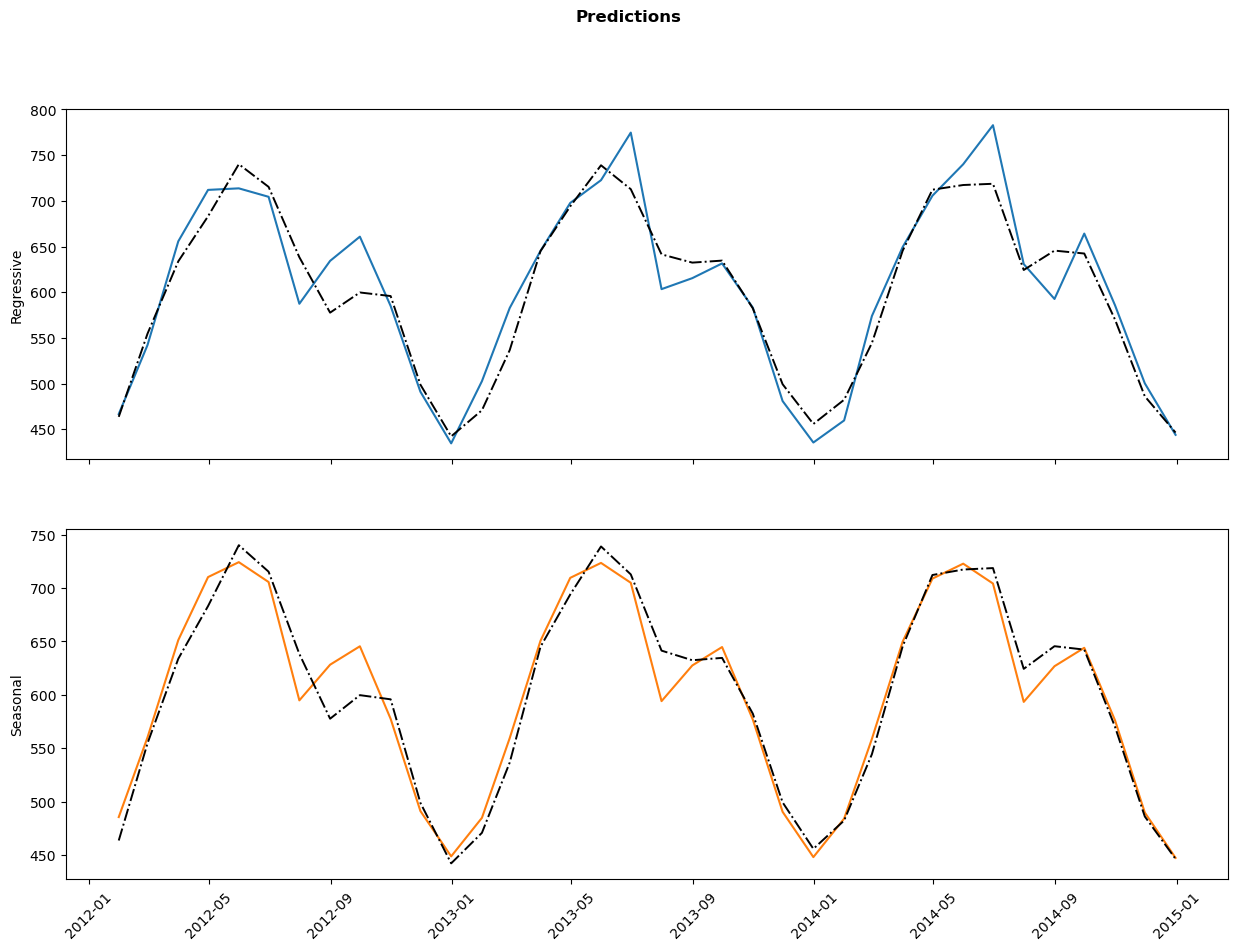

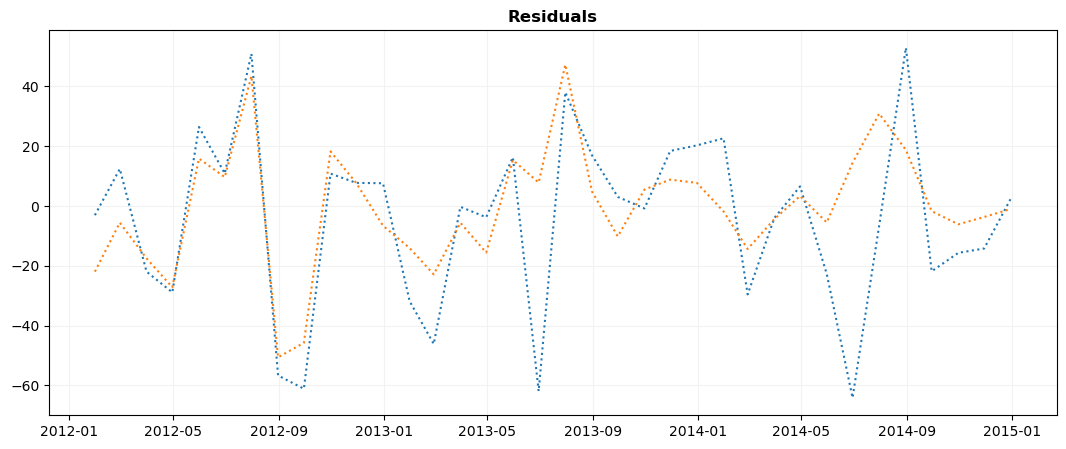

Error are :- 
Mean Square Error : 29.67111630011025 Mean Aboulute Error : 22.77371354571426 Mean Absolute Percentage Error : 0.03698779515721348


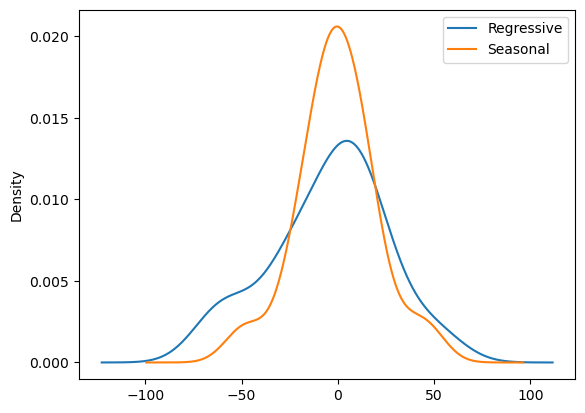

In [43]:
print("Bhadla GHI Monthly Predictions")
main_function(file[0], param[0], type[3])

# Weekly Predictions

Bhadla GHI Weekly Predictions
Shape: (784, 1)

Data Types:
 GHI    float64
dtype: object

Describe:
               GHI
count  784.000000
mean   601.032763
std     99.803342
min    396.142857
25%    513.670635
50%    614.460317
75%    688.115079
max    759.873016

Head:
                    GHI
datetime              
2000-01-02  461.277778
2000-01-09  453.317460
2000-01-16  466.476190
2000-01-23  490.365079
2000-01-30  513.952381

Tail:
                    GHI
datetime              
2014-12-07  467.634921
2014-12-14  453.111111
2014-12-21  425.111111
2014-12-28  441.539683
2015-01-04  440.925926

Missing Values:
 GHI    0
dtype: int64

Number of Unique Values:
 GHI    764
dtype: int64

Correlation Matrix:
      GHI
GHI  1.0
------------------------------
ADF Statistic : -8.728969932729822
p-value : 3.2303655721289627e-14
The series is stationary
------------------------------


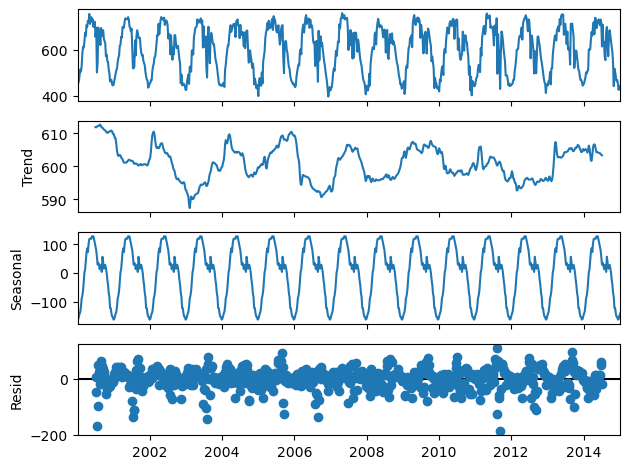

(627, 1) (157, 1) (783, 1) (783, 1)
--------------REGRESSIVE DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


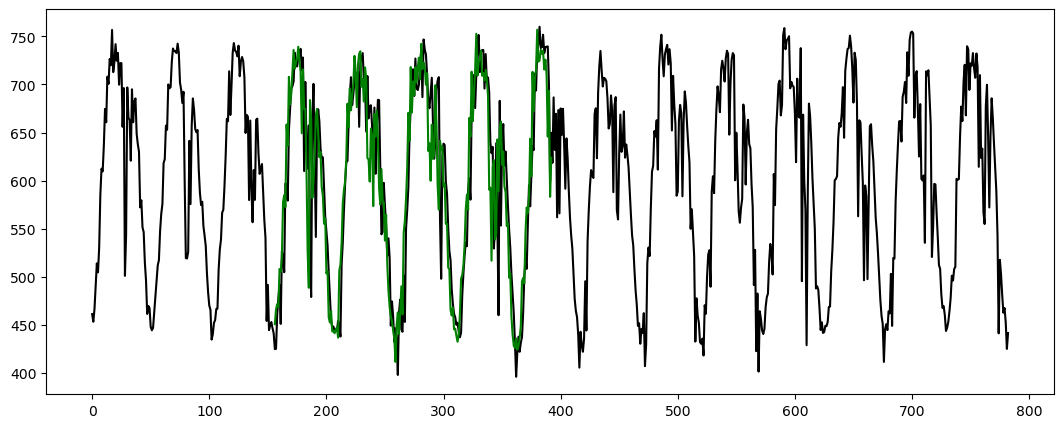

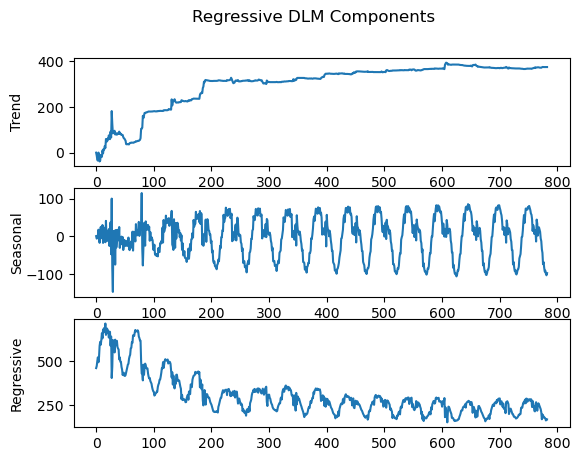

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


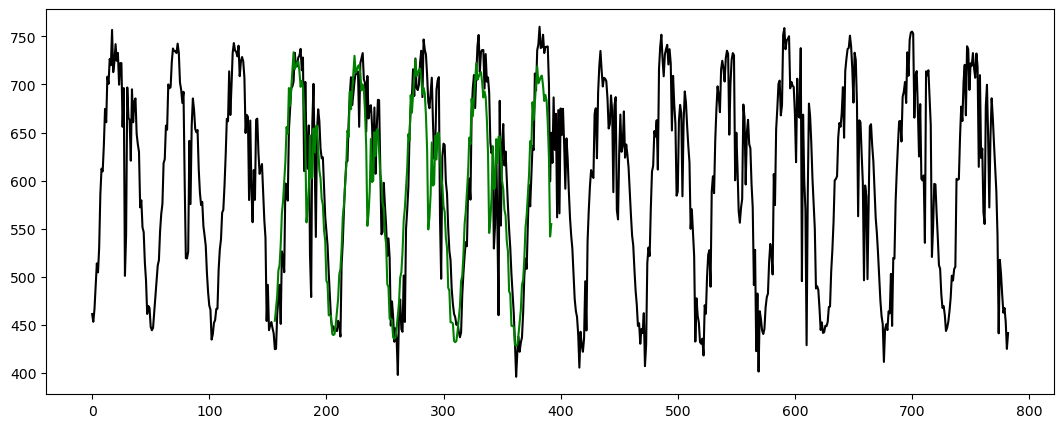

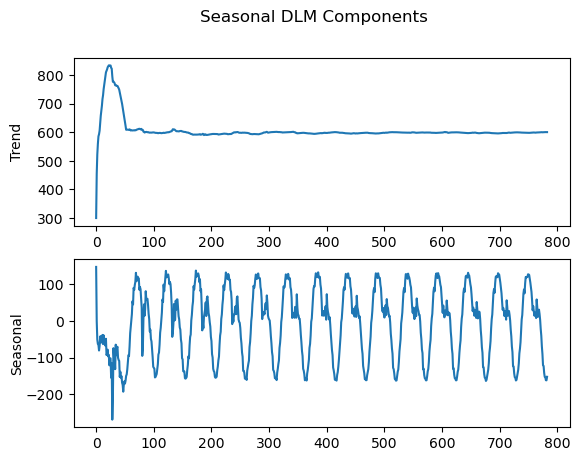

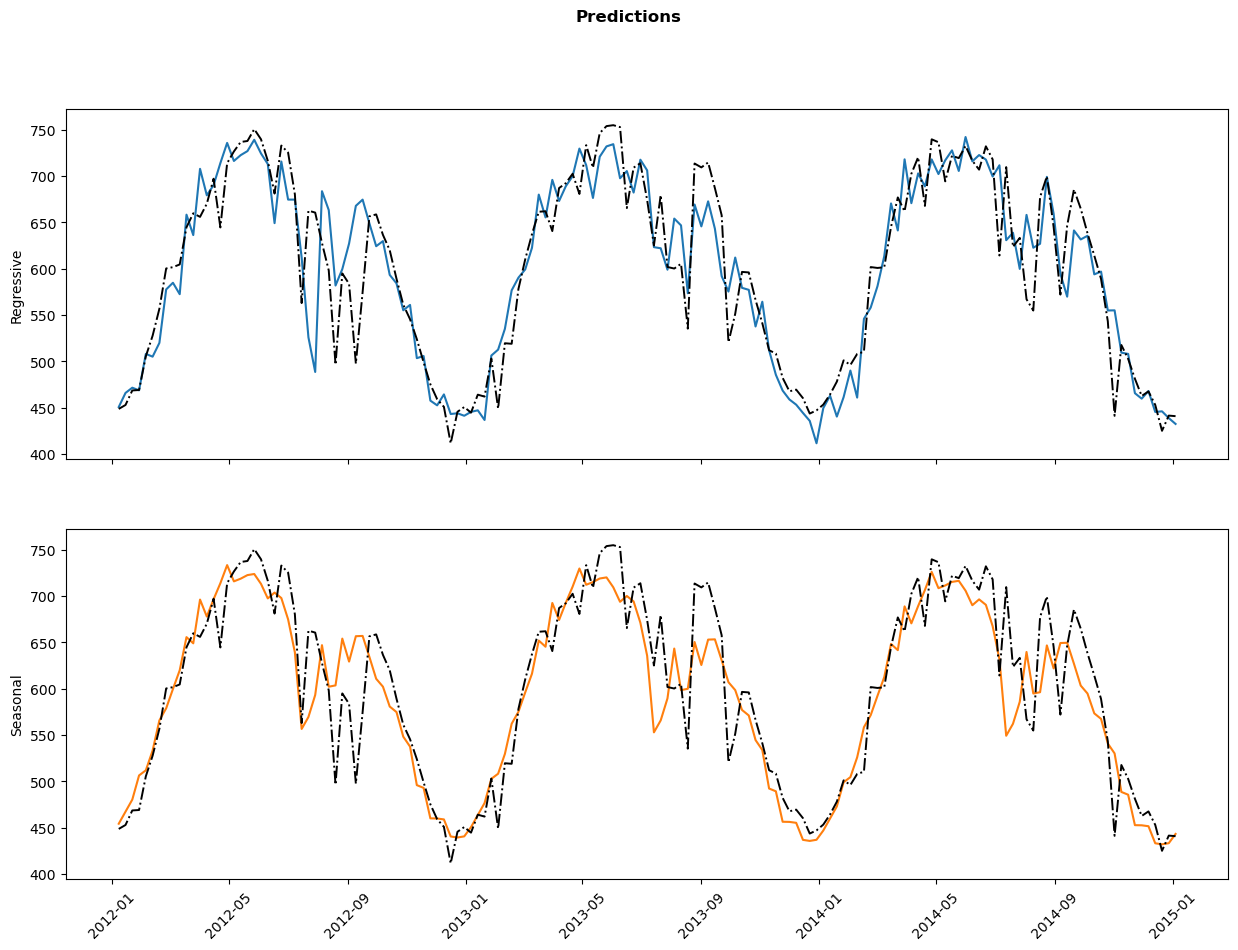

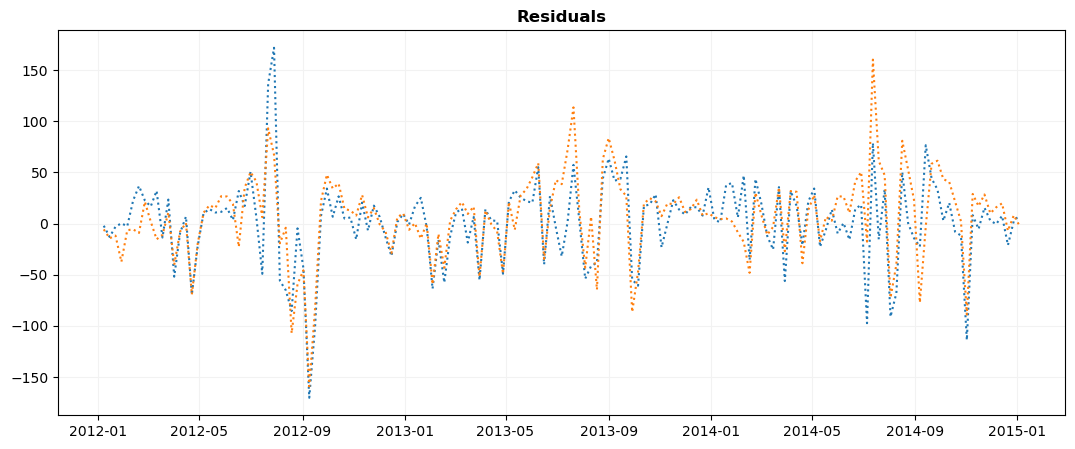

Error are :- 
Mean Square Error : 40.92175026431919 Mean Aboulute Error : 28.567158490953535 Mean Absolute Percentage Error : 0.0477270573873388


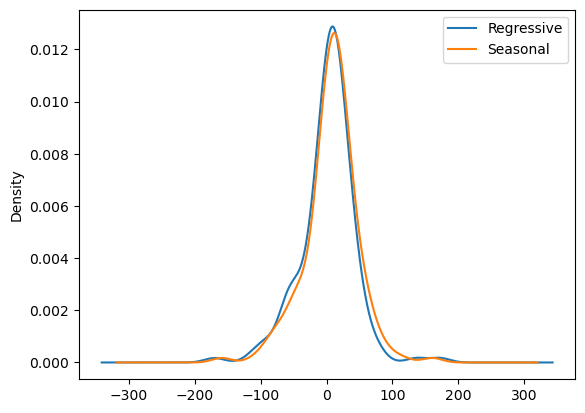

In [44]:
print("Bhadla GHI Weekly Predictions")
main_function(file[0], param[2], type[2])

**Daily Predictions**



Bhadla GHI Daily Predictions
NaN values detected!
Shape: (5479, 1)

Data Types:
 GHI    float64
dtype: object

Describe:
                GHI
count  5479.000000
mean    601.297170
std     112.195714
min     126.777778
25%     506.277778
50%     621.222222
75%     701.222222
max     769.111111

Head:
                    GHI
datetime              
2000-01-01  462.444444
2000-01-02  460.111111
2000-01-03  465.666667
2000-01-04  463.666667
2000-01-05  459.888889

Tail:
                    GHI
datetime              
2014-12-27  433.888889
2014-12-28  439.333333
2014-12-29  435.666667
2014-12-30  447.777778
2014-12-31  439.333333

Missing Values:
 GHI    0
dtype: int64

Number of Unique Values:
 GHI    2600
dtype: int64

Correlation Matrix:
      GHI
GHI  1.0
------------------------------
ADF Statistic : -5.633989464354553
p-value : 1.0734682790269621e-06
The series is stationary
------------------------------


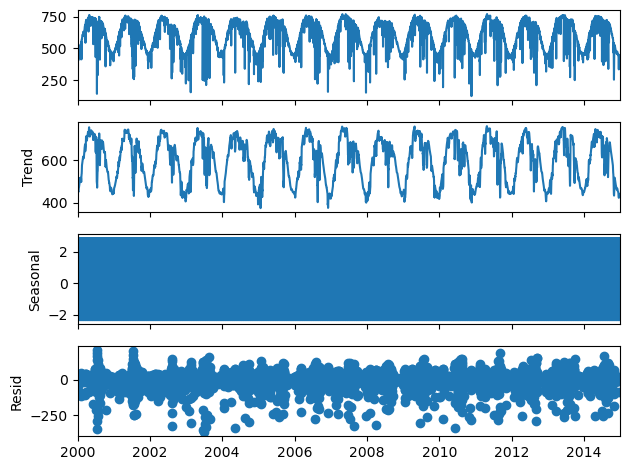

(4383, 1) (1096, 1) (5478, 1) (5478, 1)
--------------REGRESSIVE DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


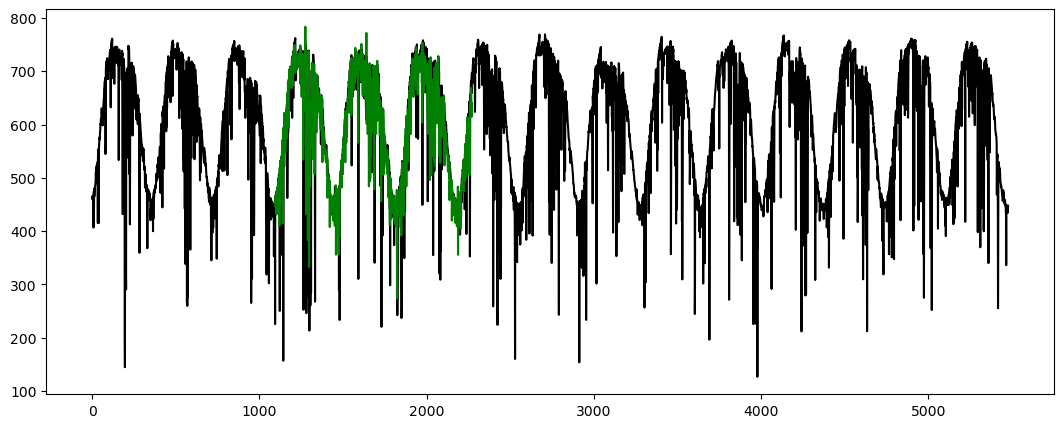

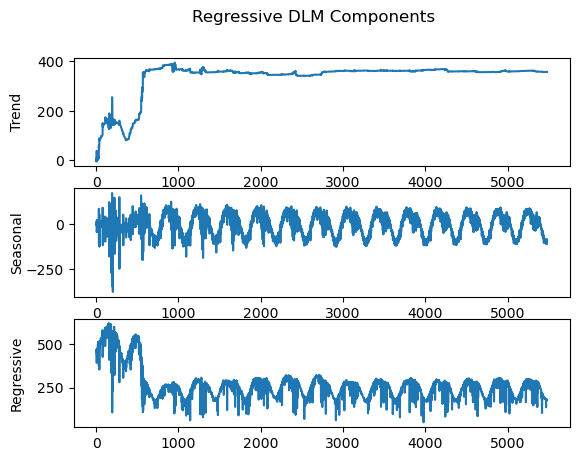

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


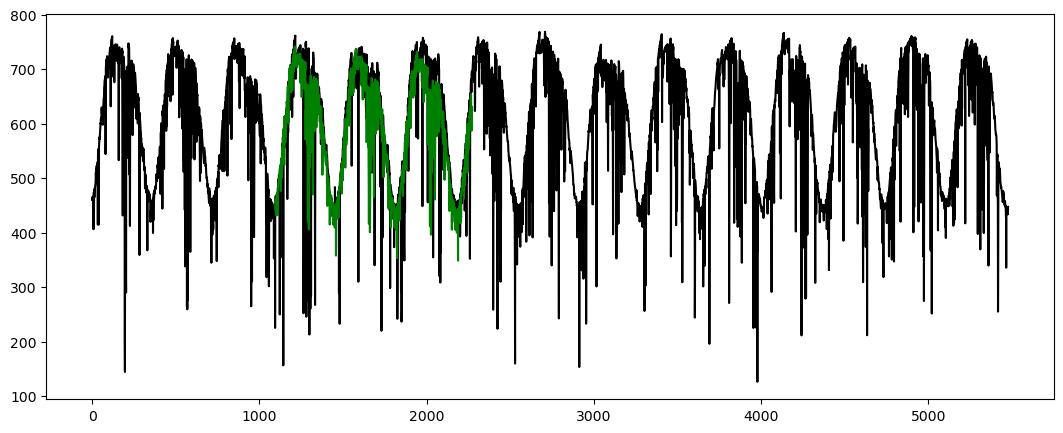

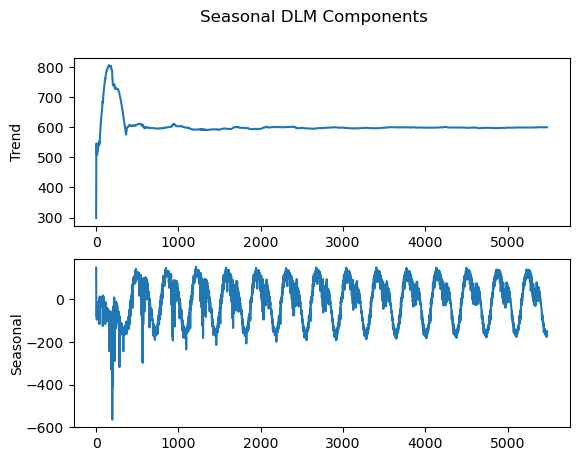

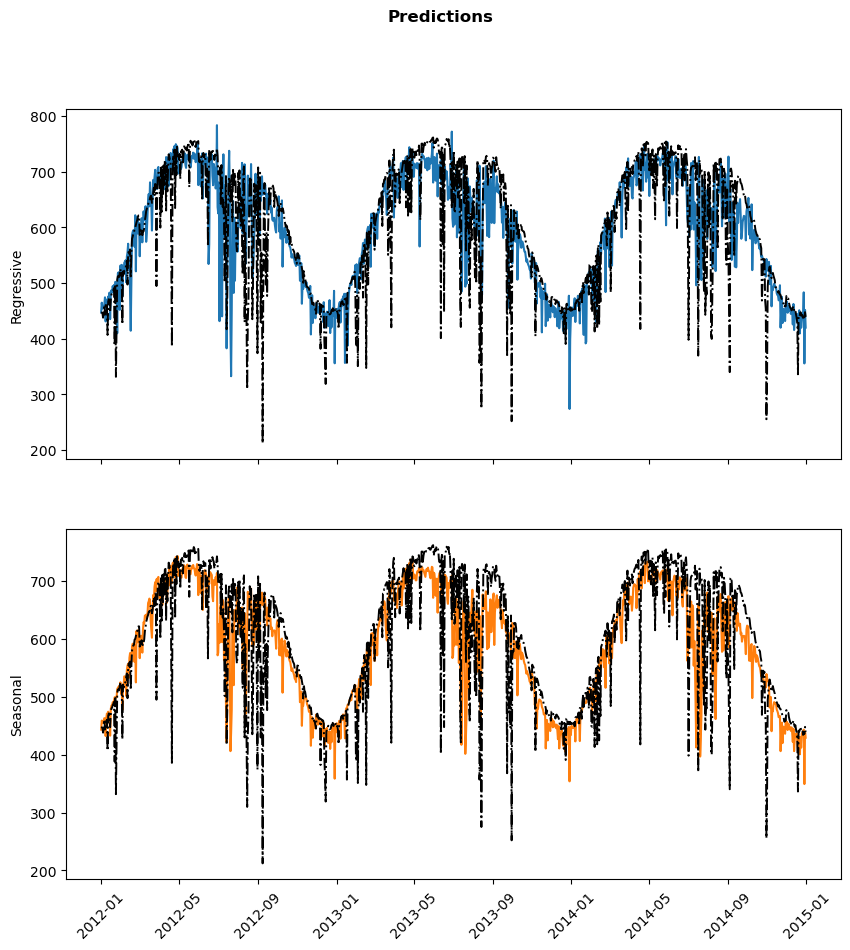

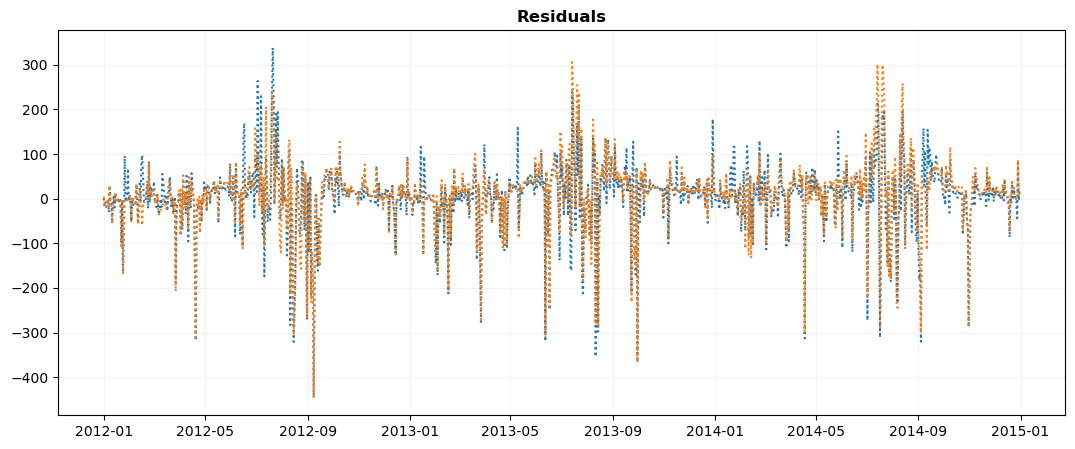

Error are :- 
Mean Square Error : 72.86841617207665 Mean Aboulute Error : 45.641205254071146 Mean Absolute Percentage Error : 0.07828200693540009


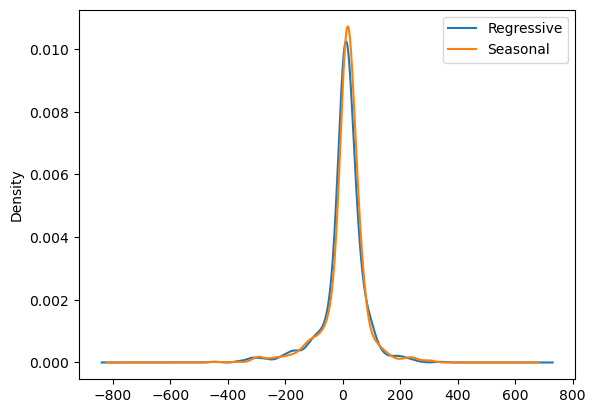

In [45]:
print("Bhadla GHI Daily Predictions")
main_function(file[1], param[0], type[1])

Bhadla GHI Hourly Predictions
Shape: (180, 1)

Data Types:
 GHI    float64
dtype: object

Describe:
               GHI
count  180.000000
mean   601.214059
std     93.343693
min    418.978495
25%    517.265013
50%    623.419056
75%    679.174612
max    745.218638

Head:
                    GHI
datetime              
2000-01-31  480.505376
2000-02-29  562.325397
2000-03-31  658.620072
2000-04-30  723.529630
2000-05-31  727.168459

Tail:
                    GHI
datetime              
2014-08-31  645.501792
2014-09-30  642.314815
2014-10-31  569.956989
2014-11-30  486.000000
2014-12-31  446.275986

Missing Values:
 GHI    0
dtype: int64

Number of Unique Values:
 GHI    180
dtype: int64

Correlation Matrix:
      GHI
GHI  1.0
------------------------------
ADF Statistic : -4.083253361187039
p-value : 0.0010321316547796105
The series is stationary
------------------------------


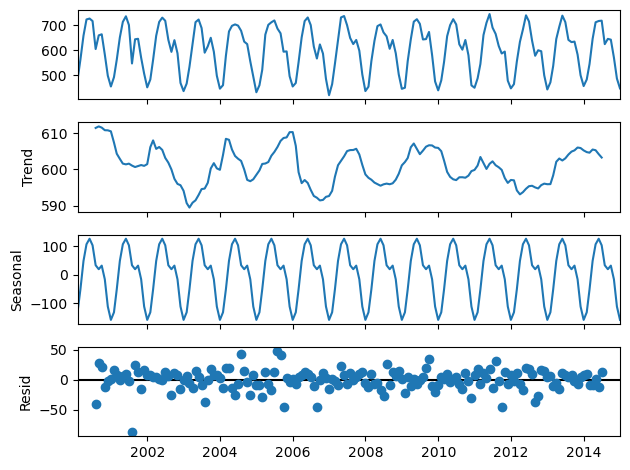

(144, 1) (36, 1) (179, 1) (179, 1)
--------------REGRESSIVE DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


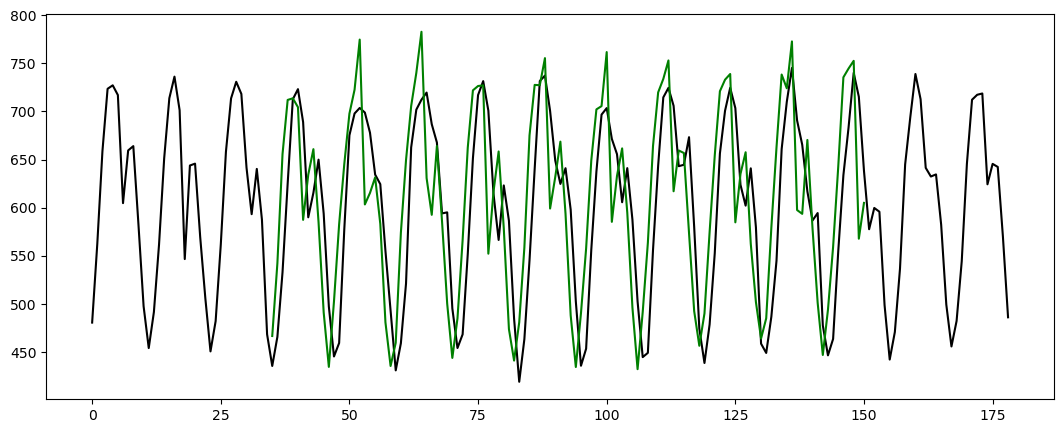

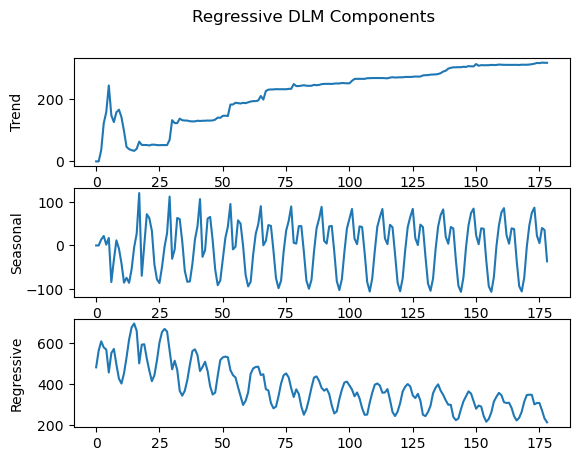

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


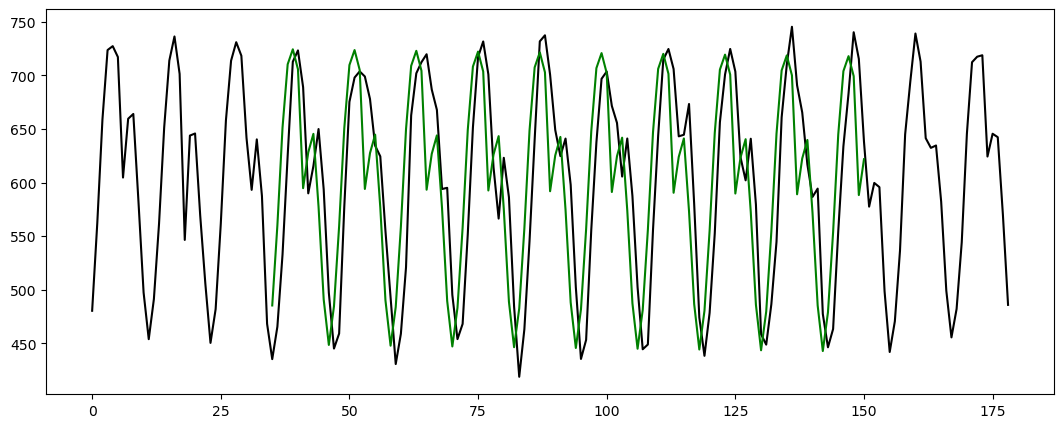

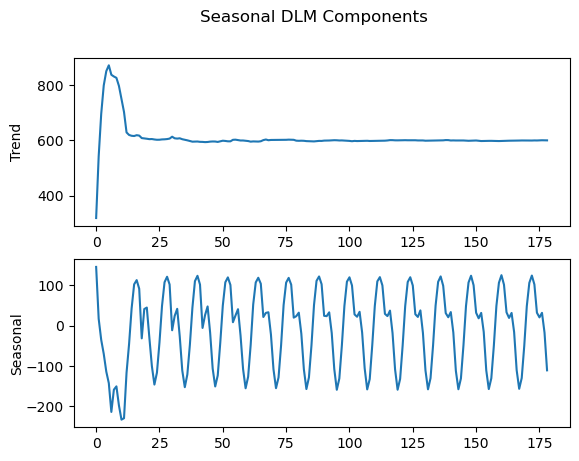

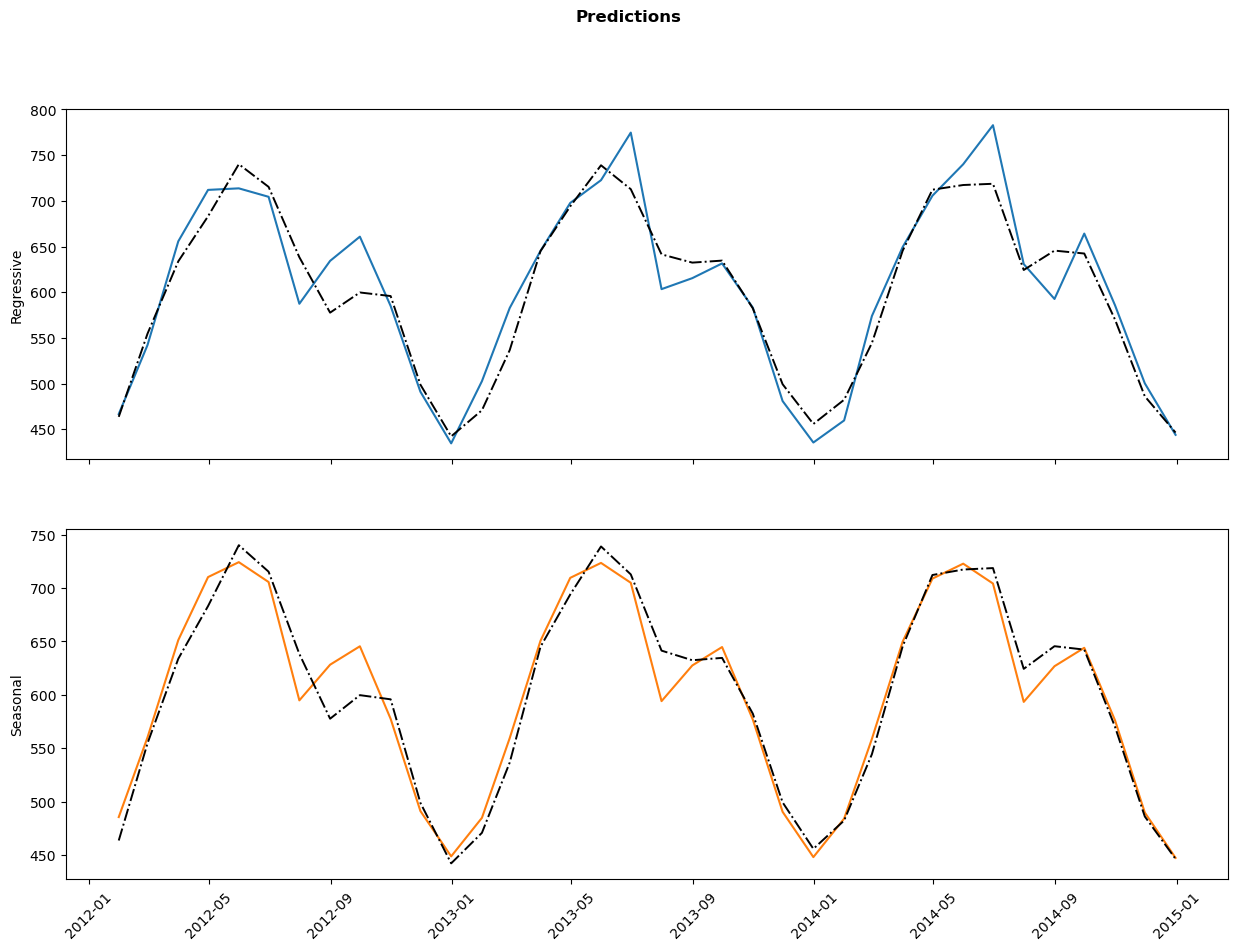

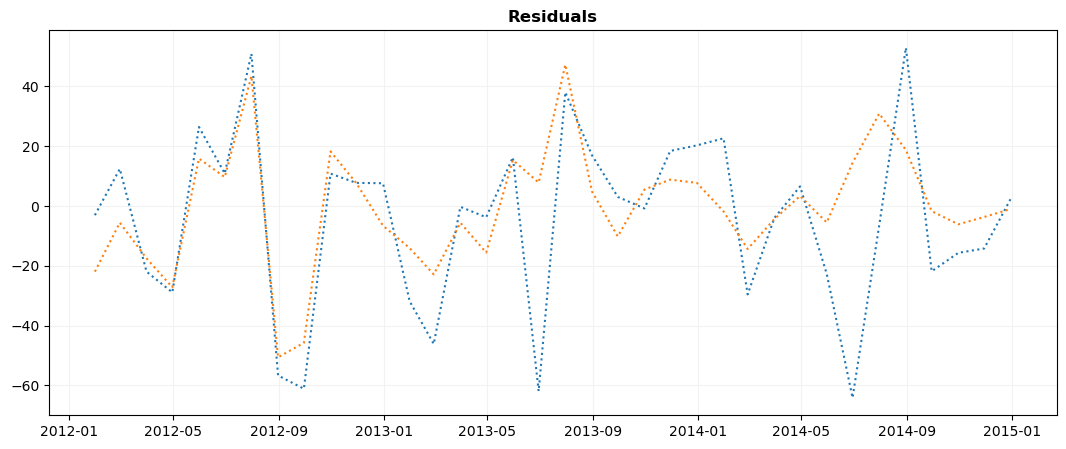

Error are :- 
Mean Square Error : 29.67111630011025 Mean Aboulute Error : 22.77371354571426 Mean Absolute Percentage Error : 0.03698779515721348


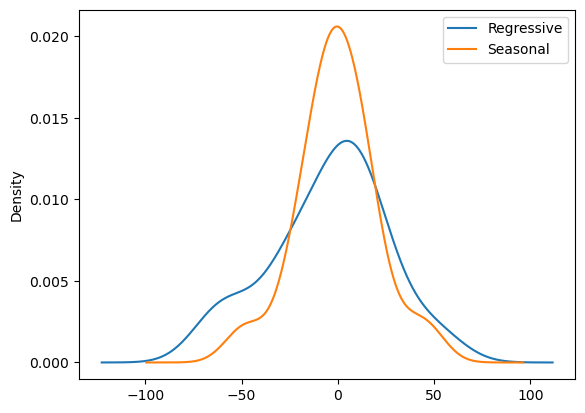

In [48]:
print("Bhadla GHI Hourly Predictions")
main_function(file[0], param[0], type[3])